<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/autoencoder-mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoder on MNIST data with TensorFlow 2

* https://blog.keras.io/building-autoencoders-in-keras.html
* https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f
* https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

dpi = 96
# dpi = 300

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15, 8)
# mpl.rcParams["figure.dpi"] = dpi
mpl.rc('xtick', labelsize=15) 
mpl.rc('ytick', labelsize=15)

font_size=15
title_font_size=25

# https://matplotlib.org/users/colormaps.html
from matplotlib.colors import ListedColormap

colors = ['#FF0000', '#0000FF', '#FFFF00']
cmap = ListedColormap(colors) 

In [2]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [3]:
import tensorflow as tf
print(tf.__version__)

2.1.0-rc1


In [0]:
tf.random.set_seed(42)

In [5]:
!nvidia-smi

Sat Dec 28 18:54:52 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## MNIST data set

In [6]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist

x_res = 28
y_res = 28
image_size = x_res * y_res

# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

can not use 2d rep as autoencoder needs to spit out flat image

In [7]:
x_train = x_train.reshape(-1, image_size)
x_test = x_test.reshape(-1, image_size)
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

In [0]:
def plot_samples(x, y, n_samples=15, labels=None):
  
  plt.gray()
  figure = plt.figure(figsize=(20, 8))
  for i, index in enumerate(np.random.choice(x_test.shape[0], size=n_samples, replace=False)):
      ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
      ax.imshow(x[index].reshape(x_res, y_res))
      if labels:
        ax.set_title("{}".format(labels[y[index]]))
      else:
        ax.set_title("{}".format(y[index]))

<Figure size 1080x576 with 0 Axes>

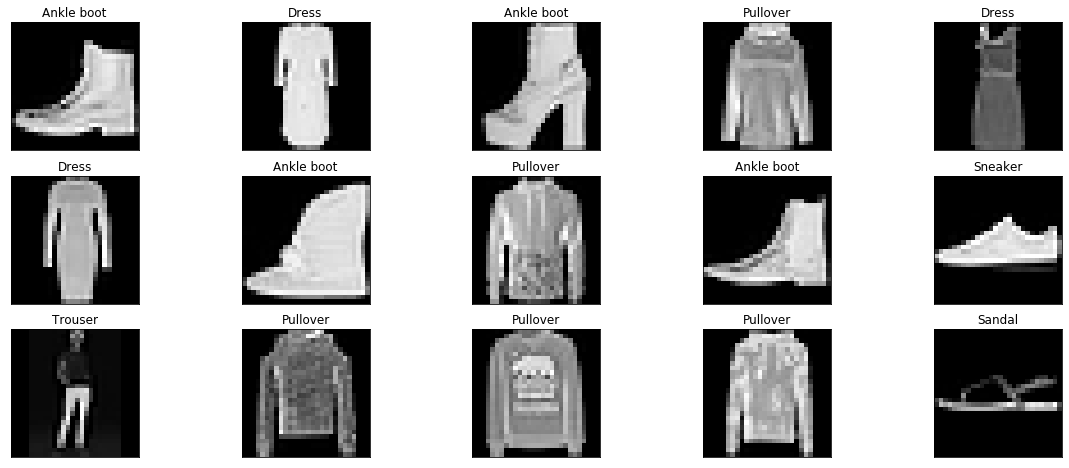

In [9]:
fashion_mnist_labels = ["T-shirt/top",  # index 0
                        "Trouser",      # index 1
                        "Pullover",     # index 2 
                        "Dress",        # index 3 
                        "Coat",         # index 4
                        "Sandal",       # index 5
                        "Shirt",        # index 6 
                        "Sneaker",      # index 7 
                        "Bag",          # index 8 
                        "Ankle boot"]   # index 9


plot_samples(x_train, y_train, labels=fashion_mnist_labels)

autoencoder using functional API

In [10]:
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten
from tensorflow.keras.models import Model

encoding_dim = 32

# input_img = Input(shape=(28, 28), name='2d_input')
input_img = Input(shape=image_size, name='1d_input')
# flattened = Flatten(name='flattened_input')(input_img)
encoded = Dense(encoding_dim, activation='relu', name='encoder')(input_img)
decoded = Dense(image_size, activation='sigmoid', name='decoder')(encoded)
# reshaped = Reshape((28, 28), name='2d_output')(decoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1d_input (InputLayer)        [(None, 784)]             0         
_________________________________________________________________
encoder (Dense)              (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


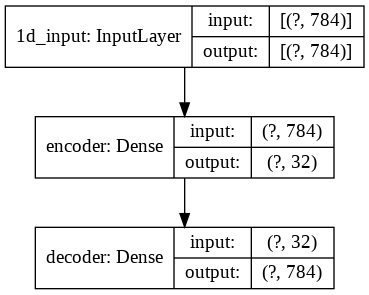

In [11]:
from tensorflow.keras.utils import plot_model

plot_model(autoencoder, show_shapes=True, dpi=dpi)

In [12]:
%%time 

BATCH_SIZE = 256
EPOCHS = 50

# binary_crossentropy seems to encourage more sparsity all by itself
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
# autoencoder.compile(optimizer='adam', loss='mse')

# we expect 0.09 for mninst and around 0.28 for fahshin mnist
history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 28us/sample - loss: 0.4145 - val_loss: 0.3425
Epoch 2/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3263 - val_loss: 0.3186
Epoch 3/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.3104 - val_loss: 0.3073
Epoch 4/50
60000/60000 [==============================] - 1s 18us/sample - loss: 0.3014 - val_loss: 0.3000
Epoch 5/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2956 - val_loss: 0.2957
Epoch 6/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2919 - val_loss: 0.2926
Epoch 7/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2894 - val_loss: 0.2909
Epoch 8/50
60000/60000 [==============================] - 1s 18us/sample - loss: 0.2878 - val_loss: 0.2894
Epoch 9/50
60000/60000 [==============================] - 1s 17us/sample - loss: 0.2868 - val_

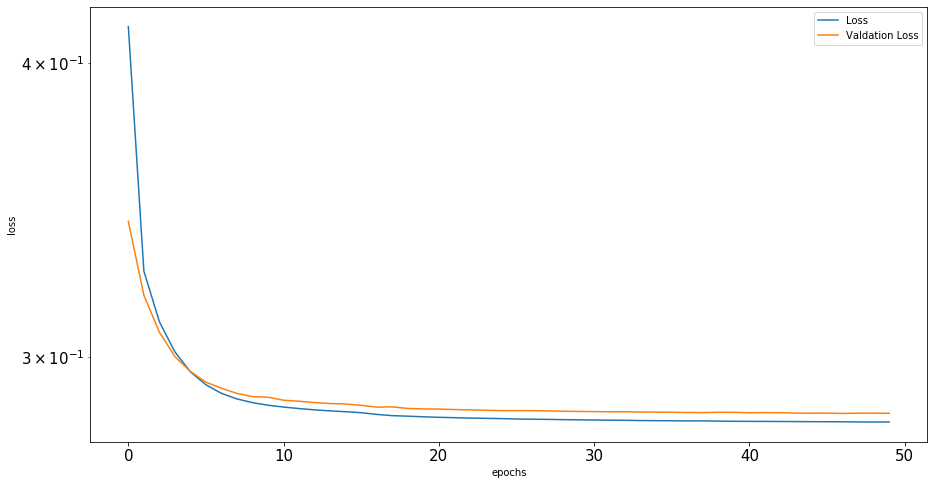

In [13]:
plt.yscale('log')

plt.ylabel("loss")
plt.xlabel("epochs")

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(["Loss", "Valdation Loss"]);

In [0]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.get_layer('decoder')
decoder = Model(encoded_input, decoder_layer(encoded_input))

embedded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(embedded_imgs)

In [0]:
# shortcut
# x_test_pred = autoencoder.predict(x_test)
x_test_pred = decoded_imgs

<Figure size 1080x576 with 0 Axes>

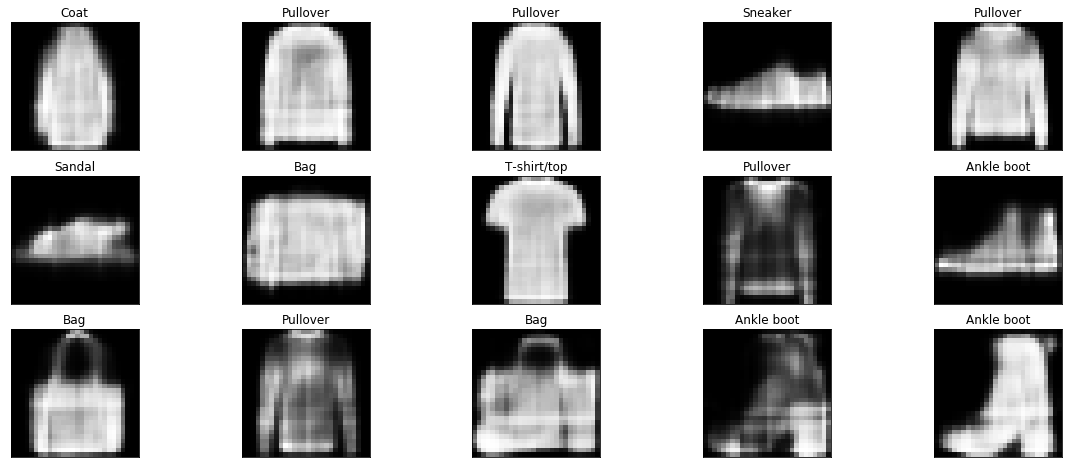

In [16]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

## let's consider the sparsity of an embedding 
### how big are the embeddings on avearge and how many zeros do the embeddings contain on average

In [17]:
embedded_imgs.shape

(10000, 32)

In [18]:
# embedding for first image
embedded_imgs[0]

array([ 3.1190462, 10.62861  ,  3.5407434,  0.       ,  2.4856448,
        2.685505 ,  5.2052474,  0.       ,  2.8165011,  5.1303024,
        6.0845175,  8.643307 ,  7.7129354,  6.4810696,  2.198099 ,
        3.2067802,  9.063464 ,  6.5347075,  8.101348 ,  8.282154 ,
        4.277429 ,  4.04232  ,  8.712006 ,  4.8522987,  2.3722847,
        3.862379 ,  5.9637785,  1.8001074,  3.3654954,  7.1567707,
        0.8744916,  3.4615965], dtype=float32)

In [19]:
tf.reduce_mean(embedded_imgs)

<tf.Tensor: shape=(), dtype=float32, numpy=4.579753>

In [20]:
# how many zeros do the embeddings contain on average
tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

<tf.Tensor: shape=(), dtype=int64, numpy=3>

## Exercise

Experiment with
* the size of the embedding
* MSE as a loss function
* mnist digits dataset instead of fashin mninst

# STOP HERE

## Adding sparsity

In [21]:
from tensorflow.keras import regularizers

encoding_dim = 32

input_img = Input(shape=(image_size,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-3))(input_img)
decoded = Dense(784, activation='sigmoid', name='decoder')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
decoder (Dense)              (None, 784)               25872     
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow import keras

@tf.function
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [23]:
%%time 

BATCH_SIZE = 256
EPOCHS = 100

autoencoder.compile(optimizer='adam', loss='binary_crossentropy', metrics=[rounded_accuracy])

# we expect 0.09 for mninst and around 0.28 for fahshin mnist
history = autoencoder.fit(x = x_train,
                    y = x_train,
                    validation_data=(x_test, x_test),
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE, 
                    verbose=1)

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 2s 29us/sample - loss: 0.4825 - rounded_accuracy: 0.7910 - val_loss: 0.3974 - val_rounded_accuracy: 0.8592
Epoch 2/100
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3732 - rounded_accuracy: 0.8776 - val_loss: 0.3603 - val_rounded_accuracy: 0.8869
Epoch 3/100
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3507 - rounded_accuracy: 0.8943 - val_loss: 0.3465 - val_rounded_accuracy: 0.8981
Epoch 4/100
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3401 - rounded_accuracy: 0.9030 - val_loss: 0.3381 - val_rounded_accuracy: 0.9049
Epoch 5/100
60000/60000 [==============================] - 1s 21us/sample - loss: 0.3329 - rounded_accuracy: 0.9089 - val_loss: 0.3319 - val_rounded_accuracy: 0.9089
Epoch 6/100
60000/60000 [==============================] - 1s 20us/sample - loss: 0.3277 - rounded_accuracy: 0.9125 - va

In [0]:
encoder = Model(input_img, encoded)

encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.get_layer('decoder')
decoder = Model(encoded_input, decoder_layer(encoded_input))

embedded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(embedded_imgs)

numbers of zeros should go up, while average should go down

In [25]:
# embedding for first image
embedded_imgs[0]

array([0.        , 0.        , 0.5640788 , 0.        , 0.        ,
       0.        , 1.1248239 , 0.21123149, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02739235, 0.39987665, 0.22738358, 0.        ,
       0.17525971, 0.        , 0.8857421 , 0.08589924, 0.12886502,
       0.77307165, 0.        , 0.        , 0.        , 0.        ,
       0.34075558, 0.        ], dtype=float32)

In [26]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.14765847>,
 <tf.Tensor: shape=(), dtype=int64, numpy=19>)

<Figure size 1080x576 with 0 Axes>

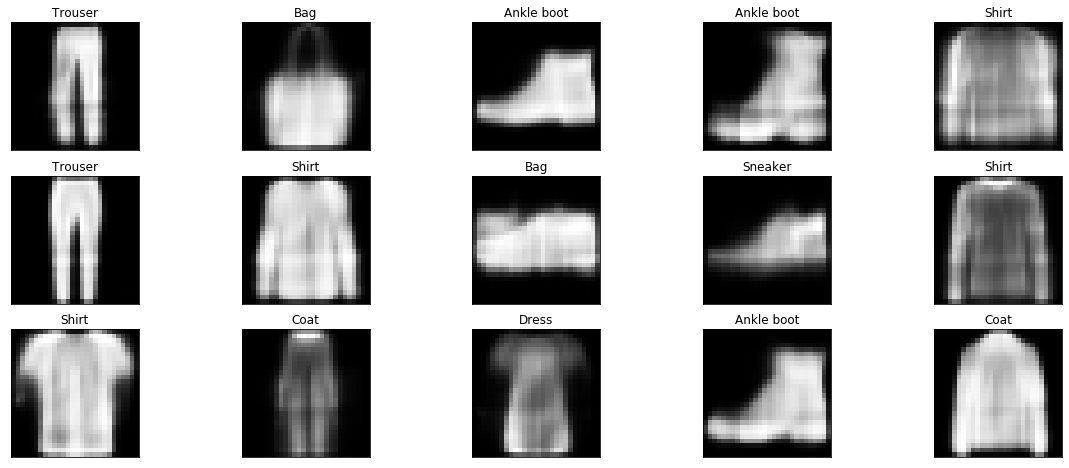

In [27]:
plot_samples(decoded_imgs, y_test, labels=fashion_mnist_labels)

## Deeper Autoencoder
https://colab.research.google.com/github/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb

In [28]:
# (x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train.shape, x_test.shape

((60000, 28, 28), (10000, 28, 28))

In [29]:
%%time

encoding_dim = 32

stacked_encoder = keras.models.Sequential([
    keras.layers.Input(shape=(x_res, y_res)),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(5e-4)),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Input(shape=encoding_dim),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(image_size, activation="sigmoid"),
    keras.layers.Reshape((x_res, y_res))
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer='adam', metrics=[rounded_accuracy])
history = stacked_ae.fit(x_train, x_train, 
                         epochs=20,
                         validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 8s 127us/sample - loss: 0.3269 - rounded_accuracy: 0.9026 - val_loss: 0.3096 - val_rounded_accuracy: 0.9163
Epoch 2/20
60000/60000 [==============================] - 7s 118us/sample - loss: 0.3047 - rounded_accuracy: 0.9189 - val_loss: 0.3047 - val_rounded_accuracy: 0.9196
Epoch 3/20
60000/60000 [==============================] - 7s 118us/sample - loss: 0.3001 - rounded_accuracy: 0.9225 - val_loss: 0.3001 - val_rounded_accuracy: 0.9232
Epoch 4/20
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2967 - rounded_accuracy: 0.9254 - val_loss: 0.2974 - val_rounded_accuracy: 0.9256
Epoch 5/20
60000/60000 [==============================] - 7s 116us/sample - loss: 0.2943 - rounded_accuracy: 0.9275 - val_loss: 0.2958 - val_rounded_accuracy: 0.9278
Epoch 6/20
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2926 - rounded_accuracy: 0.9288 - va

In [0]:
x_test_pred = stacked_ae.predict(x_test)

<Figure size 1080x576 with 0 Axes>

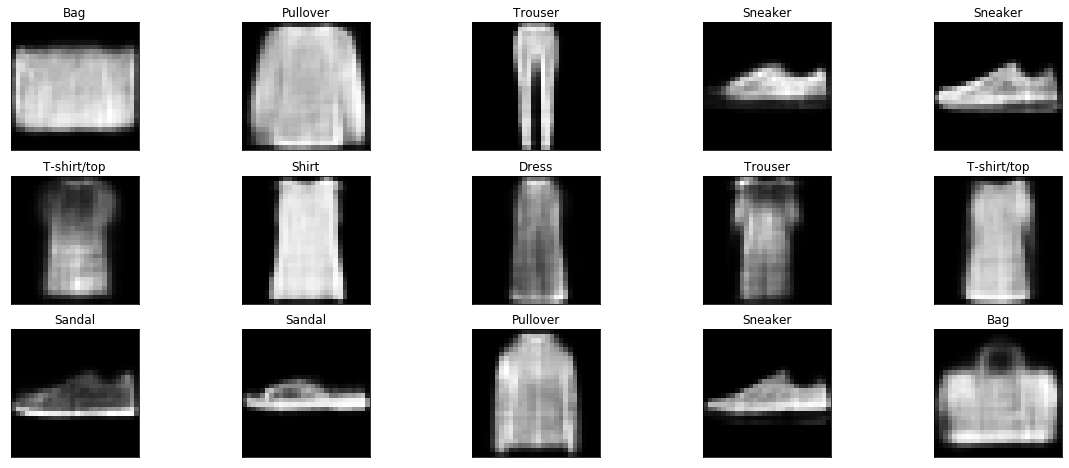

In [31]:
plot_samples(x_test_pred, y_test, labels=fashion_mnist_labels)

In [32]:
embedded_imgs = stacked_encoder.predict(x_test)
embedded_imgs.shape

(10000, 32)

In [33]:
embedded_imgs[0]

array([0.12992159, 0.        , 0.61597276, 0.        , 0.21869087,
       0.08647783, 0.        , 0.1344982 , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 1.3919469 ,
       0.        , 0.4214774 , 0.        , 0.        , 0.        ,
       0.        , 0.6634596 , 0.84897816, 0.        , 1.4240352 ,
       0.        , 0.02172848, 0.06020091, 0.        , 0.25212017,
       0.        , 0.        ], dtype=float32)

In [34]:
tf.reduce_mean(embedded_imgs), tf.reduce_mean(32 - tf.math.count_nonzero(embedded_imgs, axis=1))

(<tf.Tensor: shape=(), dtype=float32, numpy=0.18851957>,
 <tf.Tensor: shape=(), dtype=int64, numpy=18>)